In [1]:
import numpy as np
import math
from scipy.fftpack import fft, ifft,fftfreq
import math
from scipy.signal.windows import tukey
GM_sun = 1.3271244*1e20 #   这个式子等于  G * M_sun
c =2.9979246*1e8
M_sun =1.9884099*1e30
G = 6.6743*1e-11
pc= 3.0856776*1e16
pi = np.pi
Mpc = (10**6) * pc
def inner_prod(sig1_f,sig2_f,PSD,delta_f):
    """
    Inputs:
    sig1_f, sig2_f are continuous time fourier transforms with dimensions of seconds.
    PSD (power spectral density) defined in the function below. 
    delta_f : spacing of fourier frequencies
    
    outputs: Standard inner product, dimensionless.
    """
    return (4*delta_f)*np.real(sum(sig1_f*np.conjugate(sig2_f)/PSD))

def PSD_Lisa(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = c/(2*np.pi*L)   
    
    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((10/(3*L*L))*(Poms + (4*Pacc)/(np.power(2*np.pi*f,4)))*(1 + 0.6*(f/f0)*(f/f0)) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD
def PSD_Lisa_no_Response(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = c/(2*np.pi*L)   
    
    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((1/(L*L))*(Poms + (4*Pacc)/(np.power(2*np.pi*f,4))) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD
def PSD_Tianqin(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 1.7*10**8   # Length of LISA arm
    f0 = c/(2*np.pi*L)      
    
    Poms = ((1.0*10**-12)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (1*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((10/(3*L*L))*(Poms + (4*Pacc)/(np.power(2*np.pi*f,4)))*(1 + 0.6*(f/f0)*(f/f0)) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD
def Index(alpha,beta,f,f_0):
    return alpha*np.power(f/f_0,beta)
def inner_prod_for_Index(sig1_f,sig2_f,Index,df,f_1,f_2,freq):
    freq_seq=[]
    for i in np.arange(len(sig1_f)):
        if freq[i]>=f_1 and freq[i]<=f_2:
            freq_seq=np.append(freq_seq,i)
            
    fseq=[int(x) for x in freq_seq]    
    
    return (4*df) *np.real(sum(sig1_f[fseq]*np.conjugate(sig2_f[fseq])/Index[fseq]**2))


In [2]:
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap, 
                               get_mismatch, 
                               get_fundamental_frequencies, 
                               get_separatrix, 
                               get_mu_at_t, 
                               get_p_at_t, 
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase

use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}


few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)


In [3]:
# q=1e-4#mass ratio
# # parameters
# M = 1e5
# mu=M*q
# p0 = 12.0
# e0 = 0.4
# theta = np.pi/3  # polar viewing angle
# phi = np.pi/4  # azimuthal viewing angle
# dt = 10
# dist=1
# T=0.5
# h = few(M, mu, p0, e0, theta, phi,dist=dist, dt=dt, T=T)  
# # h=h.get()
# wave1 = np.array(h)
# freq = np.array(np.arange(len(h))/dt/ len(h))
# tukey_seq=[tukey(i,len(h),1/8) for i in range(0,len(h))]
# wave1 = tukey_seq*wave1

# waveform1 = fft(wave1)
# waveform2 = np.column_stack((waveform1, freq))
# temp=waveform2.real*waveform2.real+waveform2.imag*waveform2.imag
# waveform = np.sqrt(temp)

In [4]:
import sys
import os

import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
#from config.config import config
import math
#常数
from math import pi 


#BHB waveform
def htilde(f,eps,params):
    
    """
    Here we calculate a TaylorF2 model up to 2PN which takes as input the following
    set of parameters: (log of chirp mass, symmetric mass ratio, beta).
    This can easily be changed in the first few lines where the parameters are loaded.
    The main reference is https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)].
    
    Note on spin: 
    
    The spin parameter beta is defined in Eq.(2.3a) in [arxiv:0411129].
    Notice that this quantity is constructed in such a way to be smaller or equal
    than 9.4, and of course it ranges from 0 (no spins) to this upper value. 
    The coefficient enters the phase as in Eq.(2.2) in the same paper.
    """
    
    # Load the parameters
    Mchirp_true = M_sun * np.exp(params[0])
    eta_true = params[1]
    beta_true = params[2]
    Deff = params[3]
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    # PN expansion parameter (velocity).
    
    v = (pi*G*Mchirp_true*eta_true**(-3/5)/(c**3) * f)**(1/3)
    
    # Amplitude explicitly given in terms of units of seconds. This is a Continuous 
    # Time Fourier representation of the signal in the time domain.
    
    amplitude_1 = - (Mpc/Deff)*np.sqrt((5/(24*pi)))*(GM_sun/(c**2 *Mpc))
    amplitude_2 = (pi*GM_sun/(c**3))**(-1/6) * (Mchirp_true/M_sun)**(5/6)
    amplitude = amplitude_1*amplitude_2 * f**(-7/6)
    
    # Phase: add or remove PN orders here as you see fit.
    t0 =1.
    phi0 =0.
    psi_const = 2*pi*f*t0 - 2*phi0 - pi/4
    psi1PN = (3715/756 + (55/9)*eta_true)*v**(-3)
    psi1_5PN_tails = -16*pi*v**(-2)
    psi1_5PN_spin = 4*beta_true*v**(-2)
    
    psi2PN = (15293365/508032+(27145/504)*eta_true+(3085/72)*eta_true**2)*v**(-1)
    psi25PNlog = pi*(38645/252- (65/3) *eta_true)* np.log(v)
    psi3PN = v*(11583231236531/4694215680 - (640/3) * (pi**2) -6848/21 *np.euler_gamma
              + eta_true*(-15335597827/3048192 + (2255/12) * (pi**2) - 1760/3 * theta - 12320/9 * delta)
              + (eta_true**2) *76055/1728 - (eta_true**3) * 127825/1296 - 6848/21 * np.log(4))
    psi3PNlog = - 6848/21 *v * np.log(v)
    psi35PN = pi * v**2 * (77096675./254016 + (378515./1512) *eta_true - 74045./756 * (eta_true**2)* (1-eps))
    psi_fullPN = (3/(128*eta_true))*(v**(-5)+psi1PN+psi1_5PN_tails+psi1_5PN_spin+psi2PN
                                  + psi25PNlog + psi3PN + psi3PNlog + psi35PN)
    psi = psi_const + psi_fullPN 
    return amplitude* np.exp(-1j*psi)


def T_chirp(fmin,M_chirp,eta):
    """
    Calculate time elapsed until merger.
    
    """

    #M = (m1 + m2)*M_sun
    M_chirp *= M_sun
    
    M = M_chirp*eta**(-3/5)
    v_low = (pi*G*M_chirp*eta**(-3/5)/(c**3) * fmin)**(1/3)
    
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    gamma = np.euler_gamma
    
    pre_fact = ((5/(256*eta)) * G*M/(c**3))
    first_term = (v_low**(-8) + (743/252 + (11/3) * eta ) * (v_low **(-6)) - (32*pi/5)*v_low**(-5)
                +(3058673/508032 + (5429/504)*eta + (617/72)*eta**2)*v_low**(-4)
                 +(13*eta/3 - 7729/252)*pi*v_low**-3)
    
    second_term = (6848*gamma/105 - 10052469856691/23471078400 + 128*pi**2/3 + (
    3147553127/3048192 - 451*(pi**2)/12)*eta - (15211*eta**2)/1728 + (2555*eta**3 / 1296) +
                   (6848/105)*np.log(4*v_low))*v_low**-2
    
    third_term = ((14809/378)*eta**2 - (75703/756) * eta - 15419335/127008)*pi*v_low**-1
    return pre_fact * (first_term + second_term + third_term)

def final_frequency(M_chirp,eta):
    """
    Schwarzschild ISCO
    """
    M_tot = M_chirp*eta**(-3/5) * M_sun
    
    return (c**3)/(6*np.sqrt(6)*pi*G*M_tot)
    



In [7]:
import sys
sys.path.append("/home/ljq/code/MOO/Workspace")
from Index.TianQin import TianQin
tq=TianQin()
PSD=tq.Sn

In [9]:
pc= 3.0856776*1e16
Mpc = (10**6) * pc

fmin=1e-3
Deff = 2 * 1e3 * Mpc
beta = 6
q=1e-3
m1 = 1e6
m2 = m1*q 

M_tot = (m1 + m2)  # M_tot in kilograms
eta = (m1*m2)/(M_tot**2)  # Symmetric mass ratio [dimensionless]=
M_chirp = M_tot*eta**(3/5)  # Chirp mass in units of kilograms 


f_max = final_frequency(M_chirp,eta)  # Calculate maximum frequency (Schwarzschild ISCO frequency)
t_max = T_chirp(fmin,M_chirp,eta)     # Calculate maximum chirping time that binary radiates stuff

logMchirp = np.log(M_chirp)
pars = [logMchirp,eta,beta,Deff] # array of parameters for waveform.
eps_GR = 0
eps_AP = (4*1*1e-2)

delta_t = 1/(2*f_max) # Delta
t = np.arange(0,t_max,delta_t) 
n_t = len(t)  

delta_f = 1/(n_t*delta_t)         # Extract sampling frequency

freq_SNR_binary = np.arange(fmin,f_max,delta_f)     # Extract frequency series
n_f = len(freq_SNR_binary)

h_SNR_binary = htilde(freq_SNR_binary,eps_GR,pars)
waveform1=h_SNR_binary
freq=freq_SNR_binary

In [15]:
print(freq)

[0.001      0.0010002  0.00100039 ... 0.00439233 0.00439253 0.00439273]


In [10]:
#确定Tianqin方案的指标
f_1=0.3e-3
f_2=3e-3
f1=np.array([f_1])
f2=np.array([f_2])
dy=float(PSD(f1)/PSD(f2))
betaTianqin=1/2*math.log(dy,10)/math.log(f1/f2,10)
print(betaTianqin)
SNR_IndexforTianqin=100000
alphaTianqin=1.6e-19
indexTianqin=Index(alphaTianqin,betaTianqin,freq,1e-3)

df=freq[1]-freq[0]
alpha=1.74e-19
beta=-2.10
index=Index(alpha,beta,freq,1e-3)
print(len(waveform1))
SNR_IndexforTianqin=inner_prod_for_Index(waveform1,waveform1,indexTianqin,df,f_1,f_2,freq)
SNR_Index=inner_prod_for_Index(waveform1,waveform1,np.sqrt(PSD(freq)),df,f_1,f_2,freq)

print(SNR_IndexforTianqin,SNR_Index)
while(np.sqrt(SNR_IndexforTianqin)>np.sqrt(SNR_Index)):
    alphaTianqin+=0.01*1e-19
    indexTianqin=Index(alphaTianqin,betaTianqin,freq,1e-3)
    SNR_IndexforTianqin=inner_prod_for_Index(waveform1,waveform1,indexTianqin,df,f_1,f_2,freq)
    print("alpha:",alphaTianqin)
print(np.sqrt(SNR_IndexforTianqin))

-2.015883497287894
17286
162146.75445119897 6732.237019194305
alpha: 1.61e-19
alpha: 1.62e-19
alpha: 1.6300000000000002e-19
alpha: 1.6400000000000003e-19
alpha: 1.6500000000000004e-19
alpha: 1.6600000000000005e-19
alpha: 1.6700000000000006e-19
alpha: 1.6800000000000006e-19
alpha: 1.6900000000000007e-19
alpha: 1.7000000000000008e-19
alpha: 1.710000000000001e-19
alpha: 1.720000000000001e-19
alpha: 1.730000000000001e-19
alpha: 1.7400000000000012e-19
alpha: 1.7500000000000013e-19
alpha: 1.7600000000000014e-19
alpha: 1.7700000000000015e-19
alpha: 1.7800000000000016e-19
alpha: 1.7900000000000016e-19
alpha: 1.8000000000000017e-19
alpha: 1.8100000000000018e-19
alpha: 1.820000000000002e-19
alpha: 1.830000000000002e-19
alpha: 1.840000000000002e-19
alpha: 1.8500000000000022e-19
alpha: 1.8600000000000023e-19
alpha: 1.8700000000000024e-19
alpha: 1.8800000000000025e-19
alpha: 1.8900000000000026e-19
alpha: 1.9000000000000026e-19
alpha: 1.9100000000000027e-19
alpha: 1.9200000000000028e-19
alpha: 1.930

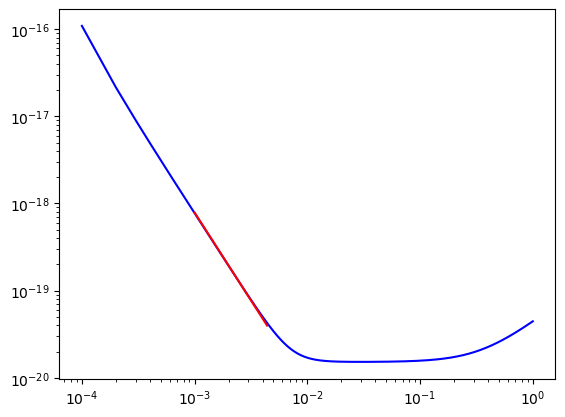

In [24]:
from matplotlib import pyplot as plt
from Index.TianQin import PlotSensitivityCurve
freq1=np.linspace(1e-4,1,10000)
plt.loglog(freq1,np.sqrt(PSD(freq1)),'b',label='Tianqin Sensitivity Curve')
plt.loglog(freq,alphaTianqin*np.power(freq/1e-3,betaTianqin),'r',label='Index for Tianqin')